In [62]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [2]:
path = 'C:\\Users\\Asus\\Desktop\\Blindness_Detection_EfficientNet\\'

In [3]:
df = pd.read_csv(path + 'train.csv', sep=',')

In [4]:
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
df["diagnosis"].value_counts() 

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [6]:
df["diagnosis"].isnull().sum()

0

<AxesSubplot:ylabel='diagnosis'>

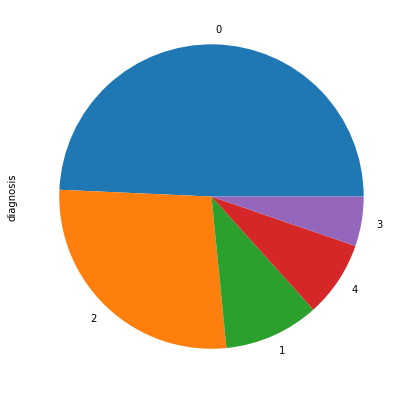

In [7]:
df["diagnosis"].value_counts().plot.pie(figsize=(7, 7))

In [8]:
df = df.sort_values(by = ["id_code"])

In [9]:
images = os.listdir(path + 'train_images')
images[0:10]

['000c1434d8d7.png',
 '001639a390f0.png',
 '0024cdab0c1e.png',
 '002c21358ce6.png',
 '005b95c28852.png',
 '0083ee8054ee.png',
 '0097f532ac9f.png',
 '00a8624548a9.png',
 '00b74780d31d.png',
 '00cb6555d108.png']

In [10]:
len(images)

3662

In [11]:
images_list = []

for img in images[0:5]:
    image = cv2.imread(path + 'train_images\\' + img)
    image = cv2.resize(image, (512,512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_list.append(image)

In [12]:
len(images_list)

5

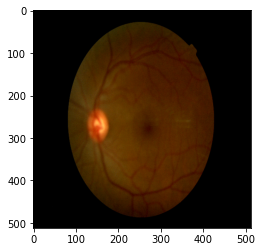

In [13]:
plt.imshow(images_list[4])

In [14]:
preprocess_img = images_list[4].copy()
preprocess_img = cv2.cvtColor(preprocess_img, cv2.COLOR_RGB2GRAY)

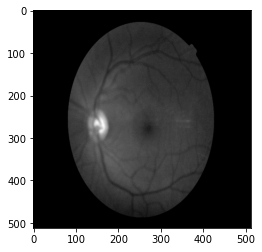

In [15]:
plt.imshow(preprocess_img, cmap='gray')

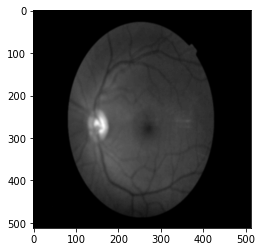

In [16]:
blur = cv2.GaussianBlur(preprocess_img,(5,5),0)
plt.imshow(blur, cmap='gray')

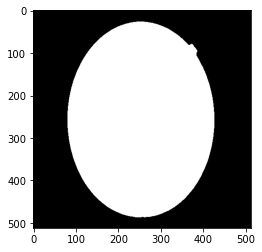

In [17]:
thresh = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1] #sadece görüntü
plt.imshow(thresh, cmap='gray')

In [18]:
contour = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0]
contour.shape

(1160, 1, 2)

In [19]:
contour = contour[:,0,:]
contour.shape

(1160, 2)

In [20]:
xmax = tuple(contour[contour[:,0].argmax()])[0]

In [21]:
xmin = tuple(contour[contour[:,0].argmin()])[0]

In [22]:
ymax = tuple(contour[contour[:,1].argmax()])[1]

In [23]:
ymin = tuple(contour[contour[:,1].argmin()])[1]

In [24]:
xmin, ymax, xmax, ymin

(81, 486, 425, 27)

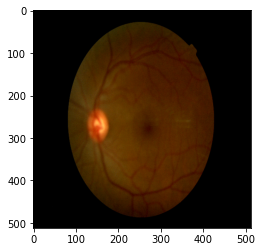

In [25]:
original = images_list[4].copy()
plt.imshow(original)

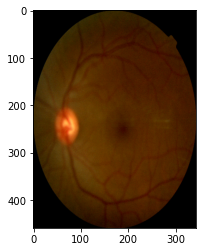

In [26]:
cropped = original[ymin:ymax, xmin:xmax]
plt.imshow(cropped)

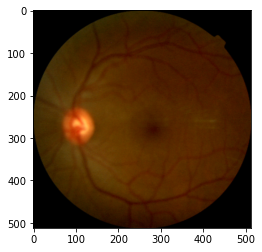

In [27]:
cropped = cv2.resize(cropped,(512,512))
plt.imshow(cropped)

In [28]:
cropped.shape

(512, 512, 3)

In [29]:
lab = cv2.cvtColor(cropped, cv2.COLOR_RGB2LAB)

(512, 512, 3)

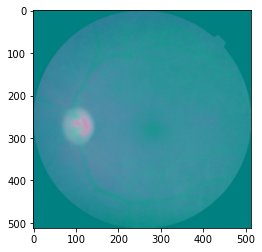

In [30]:
plt.imshow(lab)
lab.shape

In [31]:
l,a,b = cv2.split(lab)

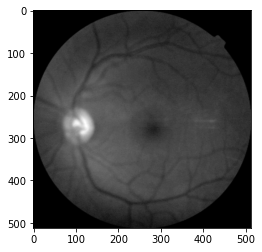

In [32]:
plt.imshow(l, cmap="gray")

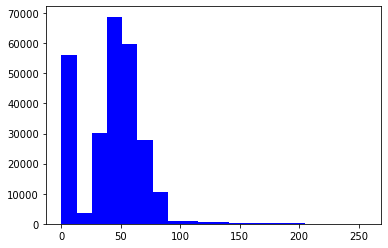

In [33]:
plt.hist(l.flatten(),20,[0,256],color = "b")
plt.show()

In [34]:
clahe = cv2.createCLAHE(clipLimit=7.0,tileGridSize=(8,8  ))
clh_img = clahe.apply(l)

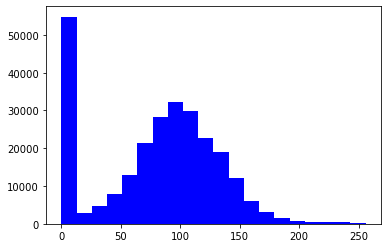

In [35]:
plt.hist(clh_img.flatten(),20,[0,256],color = "b")
plt.show()

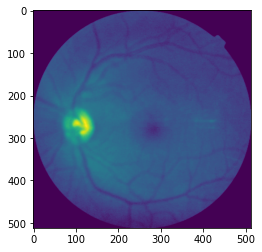

In [36]:
plt.imshow(l)

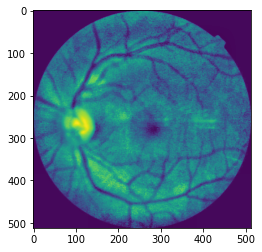

In [37]:
plt.imshow(clh_img)

In [38]:
detailed_img = cv2.merge((clh_img,a,b))
detailed_img = cv2.cvtColor(detailed_img, cv2.COLOR_LAB2RGB)

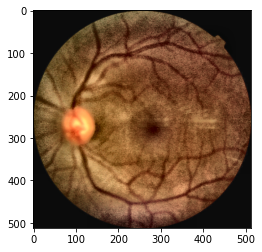

In [39]:
plt.imshow(detailed_img)

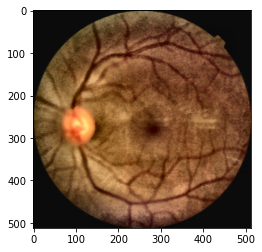

In [40]:
med_img = cv2.medianBlur(detailed_img, 3)
plt.imshow(med_img)

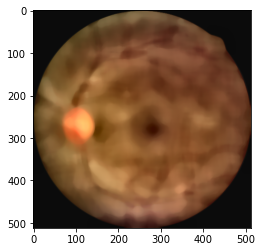

In [41]:
background = cv2.medianBlur(med_img,25)
plt.imshow(background)

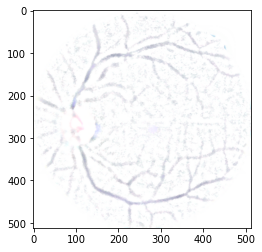

In [42]:
mask = cv2.addWeighted(med_img,1,background,-1,255)
plt.imshow(mask)

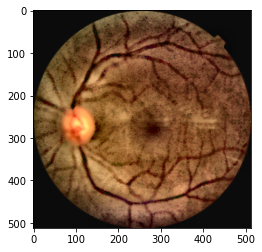

In [43]:
bitwise_img = cv2.bitwise_and(mask,med_img)
plt.imshow(bitwise_img)

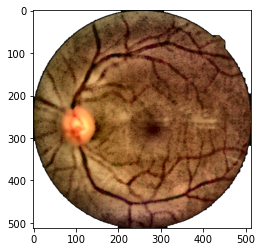

In [44]:
#round cropping
pre = bitwise_img.copy()
pre = cv2.cvtColor(pre, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(pre,(5,5),0)
ret, mask = cv2.threshold(blur, 13, 255, cv2.THRESH_BINARY) 
kernel = np.ones((9,9), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

result = bitwise_img.copy()
result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
result[:, :, 3] = mask
plt.imshow(result)

In [45]:
images_list = []

for img in tqdm(images):
    image = cv2.imread(path + 'train_images\\' + img)
    image = cv2.resize(image, (512,512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original = image.copy()
    lab = cv2.cvtColor(original, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=7.0,tileGridSize=(8,8))
    clh_img = clahe.apply(l)
    detailed_img = cv2.merge((clh_img,a,b))
    detailed_img = cv2.cvtColor(detailed_img, cv2.COLOR_LAB2RGB)
    med_img = cv2.medianBlur(detailed_img, 3)
    background = cv2.medianBlur(med_img,25)
    mask = cv2.addWeighted(med_img,1,background,-1,255)
    bitwise_img = cv2.bitwise_and(mask,med_img)
    
    #round cropping
    pre = bitwise_img.copy()
    pre = cv2.cvtColor(pre, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(pre,(5,5),0)
    ret, maskmorhp = cv2.threshold(blur, 27, 255, cv2.THRESH_BINARY) 
    kernel = np.ones((21,21), np.uint8)
    maskmorhp = cv2.morphologyEx(maskmorhp, cv2.MORPH_CLOSE, kernel)
    maskmorhp = cv2.morphologyEx(maskmorhp, cv2.MORPH_OPEN, kernel)
    result = bitwise_img.copy()
    result = cv2.cvtColor(result, cv2.COLOR_BGR2BGRA)
    result[:, :, 3] = maskmorhp
    
    images_list.append(result)

C:\Users\Asus\AppData\Local\Temp\ipykernel_19784\2495465388.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(images):


  0%|          | 0/3662 [00:00<?, ?it/s]

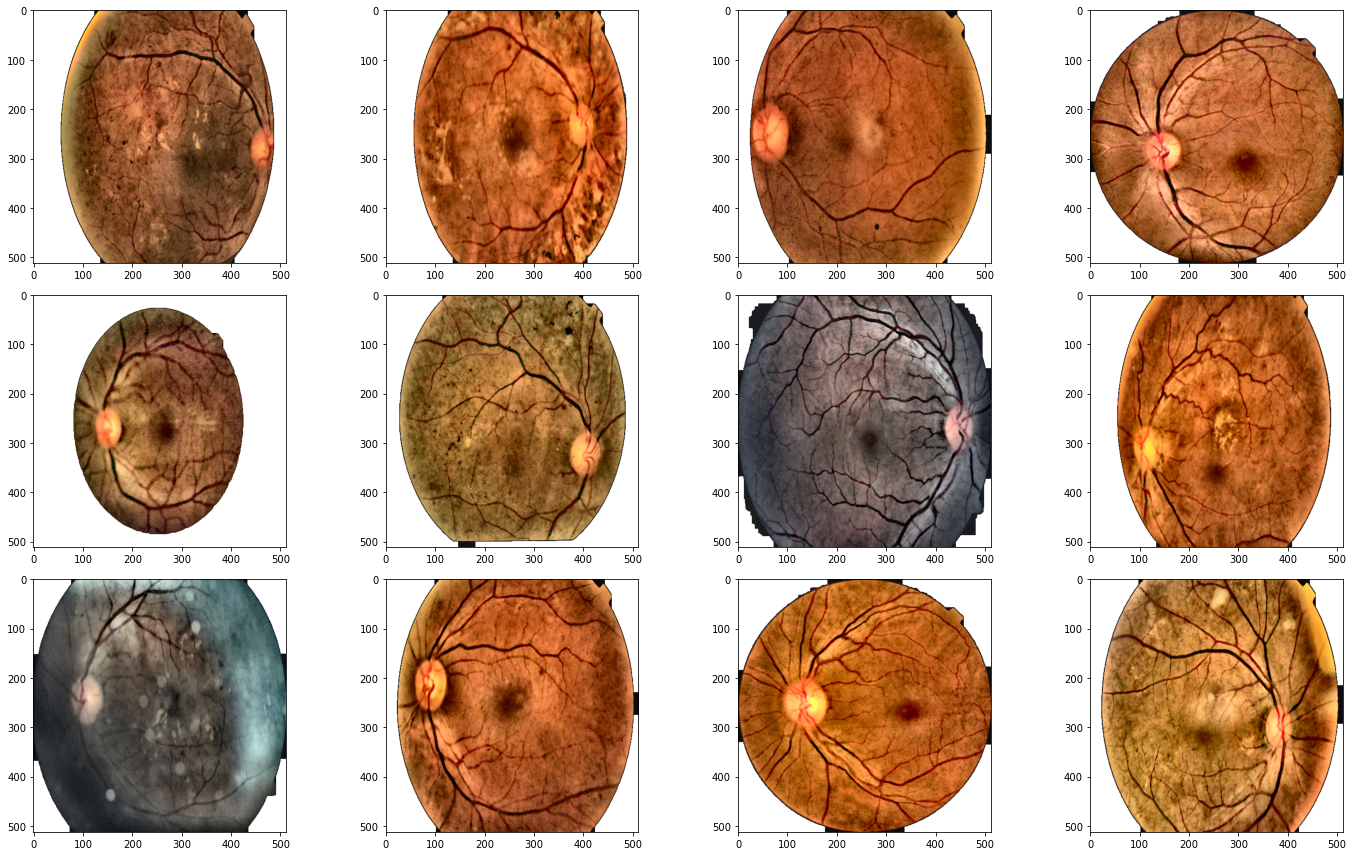

In [46]:
fig = plt.figure(figsize=(20,12))

for i in range(12):
    im = images_list[i]
    fig.add_subplot(3,4,i+1)
    plt.imshow(im)
    
plt.tight_layout()

In [47]:
y_train = pd.get_dummies(df["diagnosis"]).values
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [48]:
y_train_extra = np.ones(y_train.shape, dtype="uint8")

In [49]:
y_train_extra[:,4] = y_train[:,4] 

In [50]:
for i in range(3,-1,-1):
    y_train_extra[:,i] = np.logical_or(y_train[:,i],y_train_extra[:,i+1])

In [58]:
y_train_extra

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [59]:
x_train = np.array(images_list)

In [60]:
x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train_extra, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  shuffle=True)

In [64]:
aug_data = ImageDataGenerator(horizontal_flip=True,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              zoom_range=0.2)
data_generator = aug_data.flow(x_train,y_train,batch_size=4,seed=42)